# Lab 12: Probabilistic Reasoning

## **Reminder:**

Product rule:
$$P(A,B) = P(A|B)P(B)$$

Bayes' rule:
$$P(A|B) = \frac{P(B|A) P(A)}{P(B)}$$

Inference by enumeration:

Query variables $X$, evidence variables $E=e$, $Y$ all other variables.
$$P(X|e) = \frac{1}{P(e)} \sum_{y\in Y} P(X,e,y) $$

Conditional independence:

$A$  and $B$ are conditionally independent given $C$ iff any of the following are true:
$$P(A|B,C) = P(A|C)$$
$$P(B|A,C) = P(B|C)$$
$$P(A,B|C) = P(A|C)P(B|C)$$


Bayesian networks:
Directed acyclic graph with
- edges: dependencies, "A-->B" means "A influences probability of B", not necessarily "A causes B"
- nodes: random variables with conditional probability distributions, conditional on parents

## **Excercise 1:**

We have a bag of three biased coins a, b, and c with probabilities of coming up heads of 30%, 60%, and 75%, respectively. One coin is drawn randomly from the bag (with equal likelihood of drawing each of the three coins), and then the coin is flipped three times to generate the outcomes X1, X2, and X3.

**Question:** What is $C, X1, X2, X3$ and their values? Which variables depend on which?


**Question:** Is tossing a heads in the second round independent on tossing heads in the first one? Verify by computing $P(X1 = heads), P(X2 = heads), P(X3 = heads), P(X1 = heads, X2 = heads)$


**Task:** Draw the full probability table for just two tosses (X1 and X2). Discuss how would the toss X3 change the table itself. Can you read the conditional dependence from the table?



**Task:** Draw the Bayesian network corresponding to this setup and define the necessary conditional probability tables (CPTs).


**Task:** Calculate which coin was most likely to have been drawn from the bag if the observed flips come out heads twice and tails once.


## Hands-on

In [ ]:
!pip install pgmpy

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor

  Obtaining dependency information for pgmpy from https://files.pythonhosted.org/packages/0f/99/21be371103f6c690eb8653c1624bf1c015ab3a02f4f56da973c7b3c521b8/pgmpy-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/29/7a/8bce8968883e9465de20be15542f4c7e221952441727c4dad24d534c6d99/scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/38/f8/d8fddee9ed0d0c0f4a2132c1dfcf0e3e53265055da8df952a53e7eaf178c/pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:003.5 MB/s eta 0:00:01
  Obtaining de

Let's try to model the three coin problem.

In [ ]:
# Type aliases

Var = str
Prob = float

In [ ]:
class Model():
    def __init__(self, network: DiscreteBayesianNetwork, cpds: list[TabularCPD]):
        self.network = network
        self.network.add_cpds(*cpds)
        self.inference = VariableElimination(self.network)

    def infer(self, variables: list[Var], evidence: dict[Var, int] = {}, *args, **kwargs) -> DiscreteFactor:
        assert all([variable in self.network.nodes for variable in set(variables + list(evidence.keys()))])

        return self.inference.query(variables=variables, evidence=evidence, *args, **kwargs)

    def __str__(self):
        return ', '.join(self.network.nodes)

    def __repr__(self):
        return str(self)

In [ ]:
class CoinModel(Model):
    def __init__(self):
        cpds = self.prepare_cpds()
        network = self.prepare_network()

        super().__init__(network, cpds)

    def prepare_cpds(self) -> list[TabularCPD]:
        # Probability of drawing given coin is equal for all of the coins.
        cpd_c = TabularCPD('C', 3, [[1/3], [1/3], [1/3]])

        # A CPD for each coin given its probabilities of heads and tails.
        cpd_x1 = TabularCPD('X1', 2, [[0.3, 0.6, 0.75], [0.7, 0.4, 0.25]], evidence=['C'], evidence_card=[3])
        cpd_x2 = TabularCPD('X2', 2, [[0.3, 0.6, 0.75], [0.7, 0.4, 0.25]], evidence=['C'], evidence_card=[3])
        cpd_x3 = TabularCPD('X3', 2, [[0.3, 0.6, 0.75], [0.7, 0.4, 0.25]], evidence=['C'], evidence_card=[3])

        return [cpd_c, cpd_x1, cpd_x2, cpd_x3]

    def prepare_network(self) -> DiscreteBayesianNetwork:
        network = DiscreteBayesianNetwork([
            ('C', 'X1'),
            ('C', 'X2'),
            ('C', 'X3')
        ])

        return network

In [ ]:
coin_model = CoinModel()

Now, let's try to answer the same questions. What's $P(X1=heads)$? Heads are represented as X1(0):

In [ ]:
print(coin_model.infer(variables=['X1']))

And for the second question - which coin was most likely to have been drawn? We already know that the order of heads and tails does not matter, hence:

In [ ]:
print(coin_model.infer(variables=['C'], evidence={'X1': 0, 'X2': 0, 'X3': 1}))

Again, it's coin $b$. **Question:** The computed probabilities are different to what we computed earlier, why?



## Bayesian networks independence rules

Bayesian networks encodes conditional independence relations between nodes: 

1. Each node is conditionally independent of its non-descendants, given its parents.

2. Directional separation:
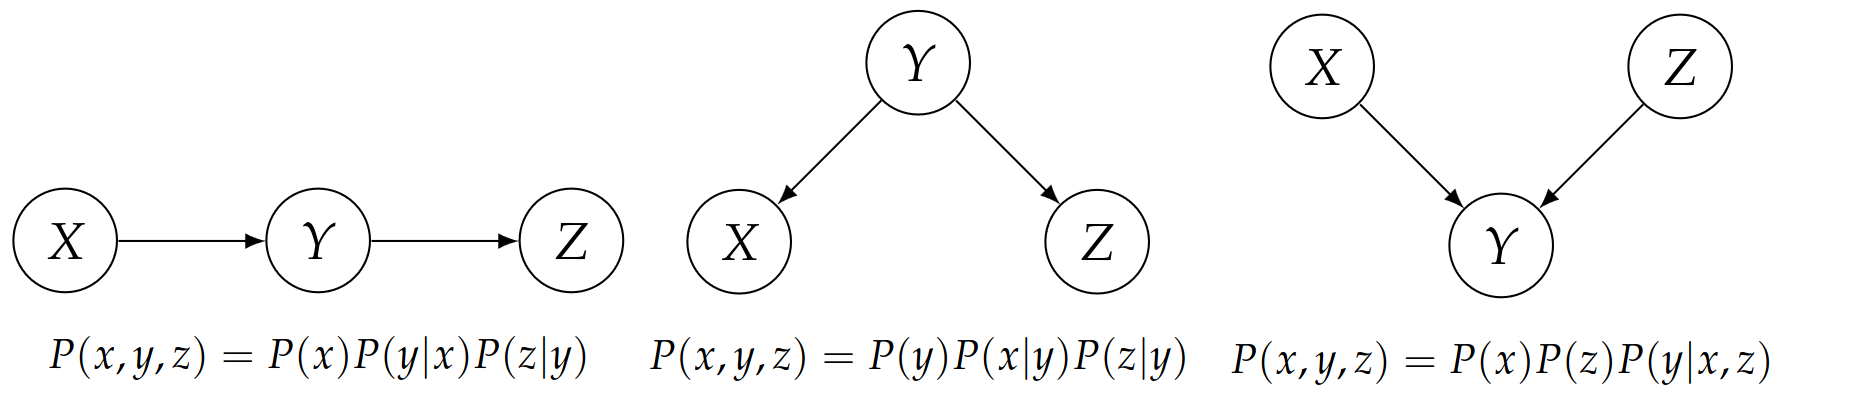

Both left and middle: X and Z does not have to be independent. But X and Z are independent given Y

Right: X and Z are independent. But X and Z given given Y are dependent.

**Question: ** Can you find a example for each of these?



## Politics inference

Let's have a different Bayes net with Boolean variables B = {BrokeElectionLaw}, I = {Indicted}, M = {PoliticallyMotivatedProsecutor}, G= {FoundGuilty}, J = {Jailed}.

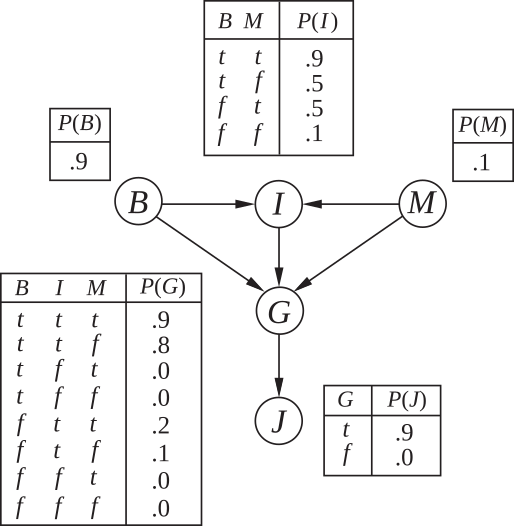

**Task:** Which of the following are asserted by the network structure?
1. $P(B,I,M)=P(B)P(I)P(M)$ 

2. $P(J|G)=P(J|G,I)$

3. $P(M|G,B,I)=P(M|G,B,I,J)$

**Task:** Compute the probability that someone broke the law, was indicted, not faced a politicaly motivated prosecutor, was found guilty and went to jail.


**Task:** Compute the probability that someone went to jail. (Formula is enough here)


**Task:** Compute the probability that someone did not break law and did not face politically motivated prosecutor yet was found guilty. (You don't need to calculate the normalization constant)



**Task:** Implement the above network using pgmpy.

In [ ]:
class PoliticsModel(Model):
    def __init__(self):
        cpds = self.prepare_cpds()
        network = self.prepare_network()

        super().__init__(network, cpds)

    def prepare_cpds(self) -> list[TabularCPD]:
        b_p = [[0.1], [0.9]]
        i_p = [[0.9, 0.5, 0.5, 0.1], [0.1, 0.5, 0.5, 0.9]]
        m_p = [[0.9], [0.1]]
        g_p = [[1. , 1. , 0.9, 0.8, 1. , 1. , 0.2, 0.1], [0., 0., 0.1, 0.2, 0., 0., 0.8, 0.9]]
        j_p = [[1.0, 0.1], [0., 0.9]]
        
        cpd_b = TabularCPD('B', 2, b_p)
        cpd_i = TabularCPD('I', 2, i_p, evidence=['B', 'M'], evidence_card=[2, 2])
        cpd_m = TabularCPD('M', 2, m_p)
        cpd_g = TabularCPD('G', 2, g_p, evidence=['B', 'I', 'M'], evidence_card=[2, 2, 2])
        cpd_j = TabularCPD('J', 2, j_p, evidence=['G'], evidence_card=[2])
        
        return [cpd_b, cpd_i, cpd_m, cpd_g, cpd_j]

    def prepare_network(self) -> DiscreteBayesianNetwork:
        network = DiscreteBayesianNetwork([('B', 'I'),
                                   ('M', 'I'),
                                   ('B', 'G'),
                                   ('I', 'G'),
                                   ('M', 'G'),
                                   ('G', 'J')])
        return network

Let's make sure it's ok...

In [ ]:
politics_model = PoliticsModel()

In [ ]:
for cpd in politics_model.network.get_cpds():
    print(cpd)

Awesome. Now let's answer the same question as above. What's the probability that someone broke the law, was indicted, not faced a politicaly motivated prosecutor, was found guilty and went to jail?

In [ ]:
print(politics_model.infer(variables=['J', 'B', 'I', 'M', 'G']))

In [ ]:
# Print only the row in question

print(politics_model.infer(variables=['J', 'B', 'I', 'M', 'G']).get_value(J=1, B=1, I=1, M=0, G=1))

Let's compute the examples

In [ ]:
print(politics_model.infer(variables=['J']).get_value(J=1))

In [ ]:
print(politics_model.infer(variables=['B', 'M'], evidence={'G':1}).get_value(B=0, M=0))

Let's do some other inferences now. Compute the probability that someone is innocent and went to jail.

In [ ]:
print(politics_model.infer(variables=['B'], evidence={'J': 1}))

Now compute the probability that someone is innocent, went to jail and faced politically motivated prosecutor.

In [ ]:
print(politics_model.infer(variables=['B'], evidence={'J': 1, 'M': 1}))